### Load required libraries

In [42]:
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
import keras
from tensorflow.keras import regularizers
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input, Conv1D, MaxPool1D, Conv1DTranspose, UpSampling1D, SeparableConv1D, Flatten, Reshape
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### Load the data

In [43]:
df = pd.read_csv('./data/creditcard.csv', index_col=0)
print(df.shape)
df.head()

(284807, 30)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,,,,,,,,,,,,,,,,,,,,,
0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### Data check

In [44]:
df['Class'].value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

In [45]:
df.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class'],
      dtype='object')

In [46]:
df.isnull().values.any()

False

In [47]:
df = df.drop(['Amount'], axis=1)

### Train/test split

In [48]:
frauds = df[df.Class == 1]
#normal = df[df.Class == 0].sample(1000)
normal = df[df.Class == 0]
print("Frauds shape: {}".format(frauds.shape))
print("Normal shape: {}".format(normal.shape))

Frauds shape: (492, 29)
Normal shape: (284315, 29)


In [49]:
data = pd.concat([frauds, normal])
data.shape

(284807, 29)

In [50]:
X_train, X_test = train_test_split(data, test_size=0.3, random_state=42)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
X_train = X_train.values

X_test, y_test = X_test.drop(['Class'], axis=1).values, X_test['Class'].values

print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))

X_train shape: (199013, 28)
X_test shape: (85443, 28)


### Visualize the data with TSNE and PCA

In [51]:
x1 = df[df.Class == 1]
x2 = df[df.Class == 0].sample(1000)

dfd = x1.append(x2).sample(frac=1).reset_index(drop=True)
x = dfd.drop(['Class'], axis=1).values
y = dfd['Class'].values

SEED = 42

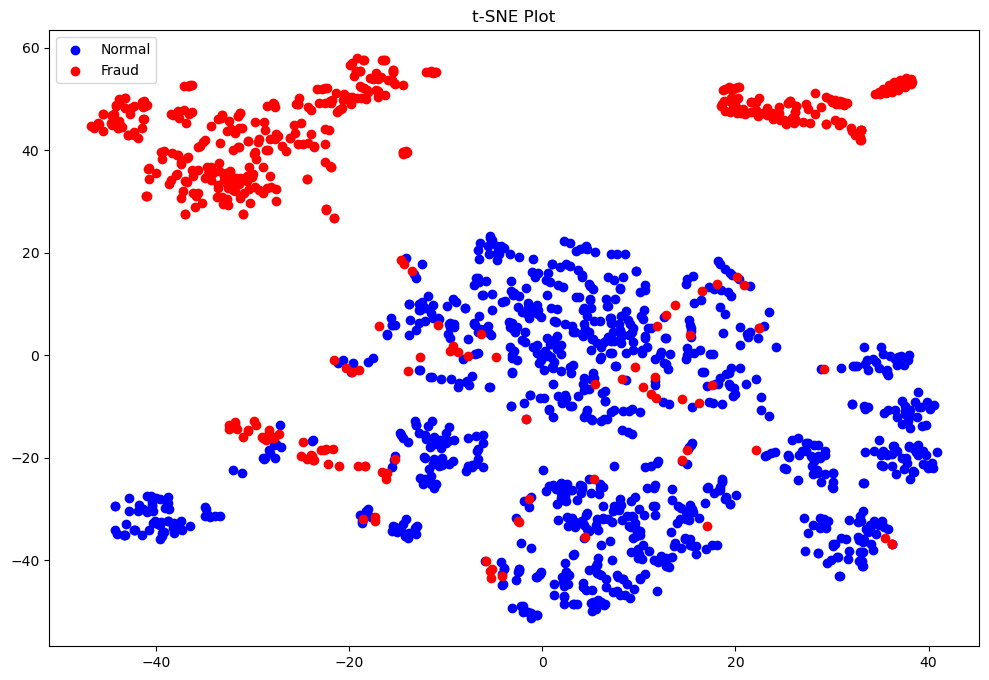

In [52]:
tsne = TSNE(n_components=2, random_state=SEED, init='random', learning_rate=200)
xtsne = tsne.fit_transform(x)
plt.figure(figsize=(12,8));
plt.scatter(xtsne[np.where(y==0), 0], y=xtsne[np.where(y==0), 1], color="blue", label='Normal')
plt.scatter(x=xtsne[np.where(y==1), 0], y=xtsne[np.where(y==1), 1], color="red", label='Fraud')
plt.title('t-SNE Plot')
plt.legend()
plt.show()

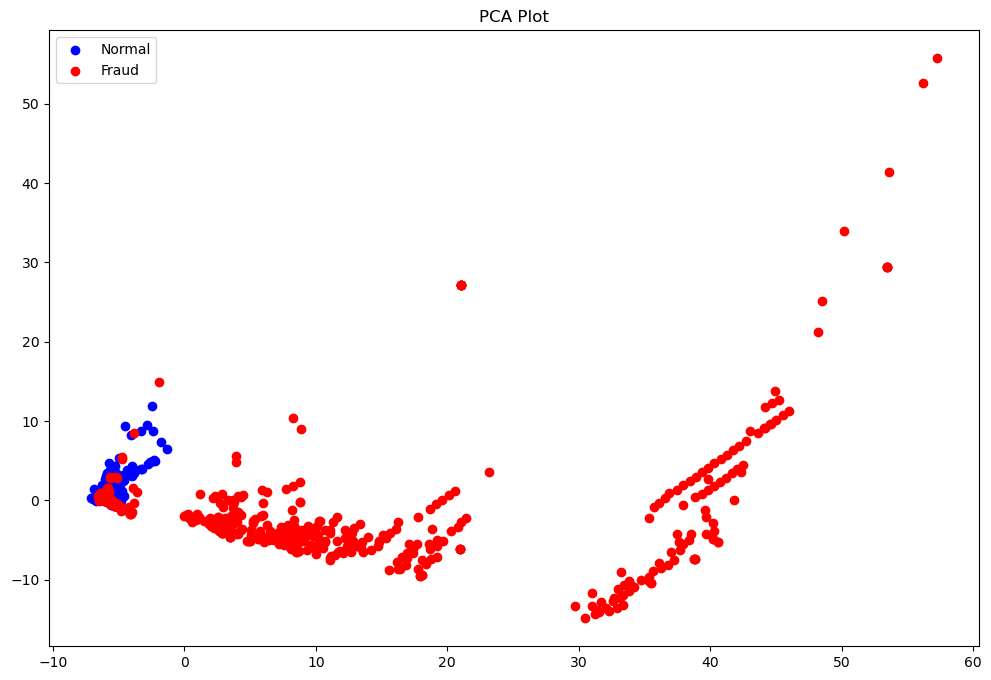

In [53]:
pca = PCA(n_components=2, random_state=SEED)
xpca = pca.fit_transform(x)
plt.figure(figsize=(12,8));
plt.scatter(x=xpca[np.where(y==0), 0], y=xpca[np.where(y==0), 1], color="blue", label='Normal')
plt.scatter(x=xpca[np.where(y==1), 0], y=xpca[np.where(y==1), 1], color="red", label='Fraud')
plt.title('PCA Plot')
plt.legend()
plt.show()

#### Normalize the data

In [54]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit_transform(X_train);
scaler.transform(X_test);

### AutoEncoder Model

In [105]:
input_dim = X_train.shape[1]

input_layer = Input(shape=(input_dim,))
encoder = Reshape((input_dim, 1,))(input_layer)
encoder = Conv1D(14, 3, padding='SAME', activation="relu")(encoder)
encoder = MaxPool1D(pool_size=2)(encoder)
encoder = Conv1D(7, 3, padding='SAME', activation="relu")(encoder)
encoder = Flatten()(encoder)

decoder = Reshape((14,7,))(encoder)
decoder = Conv1DTranspose(14, 3, padding='SAME', activation="relu")(decoder)
decoder = UpSampling1D(2)(decoder)
decoder = Conv1DTranspose(1, 3, padding='SAME', activation="relu")(decoder)
decoder = Reshape((input_dim,))(decoder)

decoder = Dense(input_dim)(decoder)
cae = Model(inputs=input_layer, outputs=decoder)

cae.summary()

Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_40 (InputLayer)       [(None, 28)]              0         
                                                                 
 reshape_59 (Reshape)        (None, 28, 1)             0         
                                                                 
 conv1d_105 (Conv1D)         (None, 28, 14)            56        
                                                                 
 max_pooling1d_73 (MaxPooli  (None, 14, 14)            0         
 ng1D)                                                           
                                                                 
 conv1d_106 (Conv1D)         (None, 14, 7)             301       
                                                                 
 flatten_7 (Flatten)         (None, 98)                0         
                                                          

In [77]:
epochs = 100
batch_size = 32
cae.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="fraudConv_AE.pth", verbose=0, save_best_only=True)

### Training

In [78]:
history = cae.fit(X_train, X_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.1,
                    callbacks=[checkpointer]).history

Epoch 1/100
5597/5598 [============================>.] - ETA: 0s - loss: 0.2785 - accuracy: 0.6624INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 34s 6ms/step - loss: 0.2785 - accuracy: 0.6624 - val_loss: 0.0665 - val_accuracy: 0.8433
Epoch 2/100
5597/5598 [============================>.] - ETA: 0s - loss: 0.0485 - accuracy: 0.8684INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 29s 5ms/step - loss: 0.0485 - accuracy: 0.8684 - val_loss: 0.0368 - val_accuracy: 0.8761
Epoch 3/100
5590/5598 [============================>.] - ETA: 0s - loss: 0.0337 - accuracy: 0.8948INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 29s 5ms/step - loss: 0.0336 - accuracy: 0.8948 - val_loss: 0.0302 - val_accuracy: 0.8994
Epoch 4/100
5596/5598 [============================>.] - ETA: 0s - loss: 0.0262 - accuracy: 0.9083INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 29s 5ms/step - loss: 0.0262 - accuracy: 0.9083 - val_loss: 0.0238 - val_accuracy: 0.9201
Epoch 5/100
5585/5598 [============================>.] - ETA: 0s - loss: 0.0242 - accuracy: 0.9157INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 29s 5ms/step - loss: 0.0242 - accuracy: 0.9158 - val_loss: 0.0182 - val_accuracy: 0.9307
Epoch 6/100
5588/5598 [============================>.] - ETA: 0s - loss: 0.0206 - accuracy: 0.9227INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 30s 5ms/step - loss: 0.0206 - accuracy: 0.9227 - val_loss: 0.0165 - val_accuracy: 0.9387
Epoch 7/100
5598/5598 [==============================] - ETA: 0s - loss: 0.0190 - accuracy: 0.9273INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 31s 6ms/step - loss: 0.0190 - accuracy: 0.9273 - val_loss: 0.0144 - val_accuracy: 0.9407
Epoch 8/100
5598/5598 [==============================] - 28s 5ms/step - loss: 0.0184 - accuracy: 0.9306 - val_loss: 0.0202 - val_accuracy: 0.9275
Epoch 9/100
5590/5598 [============================>.] - ETA: 0s - loss: 0.0176 - accuracy: 0.9334INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 33s 6ms/step - loss: 0.0176 - accuracy: 0.9334 - val_loss: 0.0130 - val_accuracy: 0.9454
Epoch 10/100
5595/5598 [============================>.] - ETA: 0s - loss: 0.0161 - accuracy: 0.9352INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 33s 6ms/step - loss: 0.0161 - accuracy: 0.9352 - val_loss: 0.0118 - val_accuracy: 0.9547
Epoch 11/100
5598/5598 [==============================] - 28s 5ms/step - loss: 0.0165 - accuracy: 0.9363 - val_loss: 0.0126 - val_accuracy: 0.9464
Epoch 12/100
5598/5598 [==============================] - 27s 5ms/step - loss: 0.0150 - accuracy: 0.9399 - val_loss: 0.0499 - val_accuracy: 0.8449
Epoch 13/100
5596/5598 [============================>.] - ETA: 0s - loss: 0.0147 - accuracy: 0.9402INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 30s 5ms/step - loss: 0.0147 - accuracy: 0.9402 - val_loss: 0.0114 - val_accuracy: 0.9495
Epoch 14/100
5598/5598 [==============================] - 27s 5ms/step - loss: 0.0142 - accuracy: 0.9408 - val_loss: 0.0136 - val_accuracy: 0.9309
Epoch 15/100
5594/5598 [============================>.] - ETA: 0s - loss: 0.0151 - accuracy: 0.9428INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 34s 6ms/step - loss: 0.0151 - accuracy: 0.9428 - val_loss: 0.0108 - val_accuracy: 0.9627
Epoch 16/100
5587/5598 [============================>.] - ETA: 0s - loss: 0.0139 - accuracy: 0.9430INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 29s 5ms/step - loss: 0.0139 - accuracy: 0.9431 - val_loss: 0.0099 - val_accuracy: 0.9611
Epoch 17/100
5588/5598 [============================>.] - ETA: 0s - loss: 0.0130 - accuracy: 0.9465INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 28s 5ms/step - loss: 0.0130 - accuracy: 0.9465 - val_loss: 0.0096 - val_accuracy: 0.9597
Epoch 18/100
5585/5598 [============================>.] - ETA: 0s - loss: 0.0132 - accuracy: 0.9461INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 28s 5ms/step - loss: 0.0131 - accuracy: 0.9461 - val_loss: 0.0092 - val_accuracy: 0.9620
Epoch 19/100
5598/5598 [==============================] - 26s 5ms/step - loss: 0.0125 - accuracy: 0.9480 - val_loss: 0.0094 - val_accuracy: 0.9572
Epoch 20/100
5592/5598 [============================>.] - ETA: 0s - loss: 0.0126 - accuracy: 0.9483INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 28s 5ms/step - loss: 0.0126 - accuracy: 0.9483 - val_loss: 0.0089 - val_accuracy: 0.9547
Epoch 21/100
5598/5598 [==============================] - 28s 5ms/step - loss: 0.0115 - accuracy: 0.9495 - val_loss: 0.0166 - val_accuracy: 0.9131
Epoch 22/100
5598/5598 [==============================] - 27s 5ms/step - loss: 0.0116 - accuracy: 0.9497 - val_loss: 0.0114 - val_accuracy: 0.9481
Epoch 23/100
5598/5598 [==============================] - 26s 5ms/step - loss: 0.0120 - accuracy: 0.9497 - val_loss: 0.0089 - val_accuracy: 0.9607
Epoch 24/100
5598/5598 [==============================] - 26s 5ms/step - loss: 0.0110 - accuracy: 0.9529 - val_loss: 0.0092 - val_accuracy: 0.9639
Epoch 25/100
5598/5598 [==============================] - 26s 5ms/step - loss: 0.0116 - accuracy: 0.9526 - val_loss: 0.0101 - val_accuracy: 0.9628
Epoch 26/100
5598/5598 [==============================] - 26s 5ms/step - loss: 0.0125 - accuracy: 0.9508 - val_loss: 0.0095 - val_a

INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 29s 5ms/step - loss: 0.0107 - accuracy: 0.9552 - val_loss: 0.0081 - val_accuracy: 0.9678
Epoch 28/100
5598/5598 [==============================] - 27s 5ms/step - loss: 0.0103 - accuracy: 0.9560 - val_loss: 0.0087 - val_accuracy: 0.9499
Epoch 29/100
5598/5598 [==============================] - 27s 5ms/step - loss: 0.0111 - accuracy: 0.9538 - val_loss: 0.0175 - val_accuracy: 0.9298
Epoch 30/100
5598/5598 [==============================] - 26s 5ms/step - loss: 0.0100 - accuracy: 0.9564 - val_loss: 0.0160 - val_accuracy: 0.9226
Epoch 31/100
5598/5598 [==============================] - 29s 5ms/step - loss: 0.0099 - accuracy: 0.9558 - val_loss: 0.0095 - val_accuracy: 0.9558
Epoch 32/100
5598/5598 [==============================] - 29s 5ms/step - loss: 0.0105 - accuracy: 0.9559 - val_loss: 0.0201 - val_accuracy: 0.9301
Epoch 33/100
5595/5598 [============================>.] - ETA: 0s - loss: 0.0108 - accuracy: 0.9563INFO:tensorflow:Assets written t

INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 32s 6ms/step - loss: 0.0108 - accuracy: 0.9564 - val_loss: 0.0075 - val_accuracy: 0.9719
Epoch 34/100
5598/5598 [==============================] - 29s 5ms/step - loss: 0.0102 - accuracy: 0.9567 - val_loss: 0.0082 - val_accuracy: 0.9651
Epoch 35/100
5590/5598 [============================>.] - ETA: 0s - loss: 0.0102 - accuracy: 0.9574INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 31s 6ms/step - loss: 0.0102 - accuracy: 0.9574 - val_loss: 0.0071 - val_accuracy: 0.9696
Epoch 36/100
5598/5598 [==============================] - 29s 5ms/step - loss: 0.0096 - accuracy: 0.9590 - val_loss: 0.0169 - val_accuracy: 0.9372
Epoch 37/100
5598/5598 [==============================] - 29s 5ms/step - loss: 0.0096 - accuracy: 0.9576 - val_loss: 0.0076 - val_accuracy: 0.9590
Epoch 38/100
5598/5598 [==============================] - 29s 5ms/step - loss: 0.0097 - accuracy: 0.9569 - val_loss: 0.0074 - val_accuracy: 0.9678
Epoch 39/100
5598/5598 [==============================] - 29s 5ms/step - loss: 0.0098 - accuracy: 0.9590 - val_loss: 0.0074 - val_accuracy: 0.9699
Epoch 40/100
5598/5598 [==============================] - 29s 5ms/step - loss: 0.0104 - accuracy: 0.9596 - val_loss: 0.0073 - val_accuracy: 0.9662
Epoch 41/100
5597/5598 [============================>.] - ETA: 0s - loss: 0.0091 - accuracy: 0.9594INFO:tensorflow:Assets written t

INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 31s 6ms/step - loss: 0.0091 - accuracy: 0.9594 - val_loss: 0.0068 - val_accuracy: 0.9702
Epoch 42/100
5596/5598 [============================>.] - ETA: 0s - loss: 0.0095 - accuracy: 0.9591INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 31s 6ms/step - loss: 0.0095 - accuracy: 0.9591 - val_loss: 0.0067 - val_accuracy: 0.9748
Epoch 43/100
5586/5598 [============================>.] - ETA: 0s - loss: 0.0091 - accuracy: 0.9614INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 31s 6ms/step - loss: 0.0091 - accuracy: 0.9614 - val_loss: 0.0066 - val_accuracy: 0.9747
Epoch 44/100
5598/5598 [==============================] - 27s 5ms/step - loss: 0.0097 - accuracy: 0.9604 - val_loss: 0.0092 - val_accuracy: 0.9517
Epoch 45/100
5588/5598 [============================>.] - ETA: 0s - loss: 0.0096 - accuracy: 0.9596INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 28s 5ms/step - loss: 0.0096 - accuracy: 0.9596 - val_loss: 0.0065 - val_accuracy: 0.9755
Epoch 46/100
5598/5598 [==============================] - 27s 5ms/step - loss: 0.0092 - accuracy: 0.9610 - val_loss: 0.0090 - val_accuracy: 0.9457
Epoch 47/100
5594/5598 [============================>.] - ETA: 0s - loss: 0.0094 - accuracy: 0.9613INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 28s 5ms/step - loss: 0.0094 - accuracy: 0.9613 - val_loss: 0.0065 - val_accuracy: 0.9747
Epoch 48/100
5598/5598 [==============================] - 26s 5ms/step - loss: 0.0088 - accuracy: 0.9620 - val_loss: 0.0153 - val_accuracy: 0.9192
Epoch 49/100
5598/5598 [==============================] - 26s 5ms/step - loss: 0.0087 - accuracy: 0.9619 - val_loss: 0.0092 - val_accuracy: 0.9554
Epoch 50/100
5598/5598 [==============================] - 26s 5ms/step - loss: 0.0090 - accuracy: 0.9608 - val_loss: 0.0072 - val_accuracy: 0.9638
Epoch 51/100
5593/5598 [============================>.] - ETA: 0s - loss: 0.0085 - accuracy: 0.9635INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 28s 5ms/step - loss: 0.0085 - accuracy: 0.9634 - val_loss: 0.0064 - val_accuracy: 0.9740
Epoch 52/100
5591/5598 [============================>.] - ETA: 0s - loss: 0.0087 - accuracy: 0.9620INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 28s 5ms/step - loss: 0.0087 - accuracy: 0.9620 - val_loss: 0.0063 - val_accuracy: 0.9754
Epoch 53/100
5598/5598 [==============================] - 26s 5ms/step - loss: 0.0088 - accuracy: 0.9617 - val_loss: 0.0109 - val_accuracy: 0.9328
Epoch 54/100
5598/5598 [==============================] - 26s 5ms/step - loss: 0.0081 - accuracy: 0.9628 - val_loss: 0.0083 - val_accuracy: 0.9523
Epoch 55/100
5598/5598 [==============================] - 26s 5ms/step - loss: 0.0082 - accuracy: 0.9627 - val_loss: 0.0067 - val_accuracy: 0.9740
Epoch 56/100
5593/5598 [============================>.] - ETA: 0s - loss: 0.0088 - accuracy: 0.9628INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 28s 5ms/step - loss: 0.0088 - accuracy: 0.9628 - val_loss: 0.0063 - val_accuracy: 0.9786
Epoch 57/100
5598/5598 [==============================] - 26s 5ms/step - loss: 0.0078 - accuracy: 0.9651 - val_loss: 0.0065 - val_accuracy: 0.9756
Epoch 58/100
5598/5598 [==============================] - 26s 5ms/step - loss: 0.0103 - accuracy: 0.9613 - val_loss: 0.0066 - val_accuracy: 0.9694
Epoch 59/100
5598/5598 [==============================] - 26s 5ms/step - loss: 0.0083 - accuracy: 0.9656 - val_loss: 0.0091 - val_accuracy: 0.9528
Epoch 60/100
5598/5598 [==============================] - 28s 5ms/step - loss: 0.0081 - accuracy: 0.9638 - val_loss: 0.0088 - val_accuracy: 0.9703
Epoch 61/100
5598/5598 [==============================] - 29s 5ms/step - loss: 0.0078 - accuracy: 0.9645 - val_loss: 0.0131 - val_accuracy: 0.9332
Epoch 62/100
5598/5598 [==============================] - 29s 5ms/step - loss: 0.0083 - accuracy: 0.9636 - val_loss: 0.0303 - val_a

INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 32s 6ms/step - loss: 0.0081 - accuracy: 0.9642 - val_loss: 0.0058 - val_accuracy: 0.9806
Epoch 65/100
5598/5598 [==============================] - 29s 5ms/step - loss: 0.0082 - accuracy: 0.9646 - val_loss: 0.0059 - val_accuracy: 0.9783
Epoch 66/100
5598/5598 [==============================] - 29s 5ms/step - loss: 0.0078 - accuracy: 0.9646 - val_loss: 0.0085 - val_accuracy: 0.9444
Epoch 67/100
5598/5598 [==============================] - 29s 5ms/step - loss: 0.0081 - accuracy: 0.9650 - val_loss: 0.0077 - val_accuracy: 0.9645
Epoch 68/100
5598/5598 [==============================] - 29s 5ms/step - loss: 0.0090 - accuracy: 0.9630 - val_loss: 0.0059 - val_accuracy: 0.9769
Epoch 69/100
5598/5598 [==============================] - 29s 5ms/step - loss: 0.0081 - accuracy: 0.9645 - val_loss: 0.0063 - val_accuracy: 0.9689
Epoch 70/100
5598/5598 [==============================] - 29s 5ms/step - loss: 0.0080 - accuracy: 0.9659 - val_loss: 0.0088 - val_a

INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 31s 6ms/step - loss: 0.0078 - accuracy: 0.9670 - val_loss: 0.0055 - val_accuracy: 0.9798
Epoch 83/100
5598/5598 [==============================] - 29s 5ms/step - loss: 0.0076 - accuracy: 0.9680 - val_loss: 0.0056 - val_accuracy: 0.9802
Epoch 84/100
5598/5598 [==============================] - 28s 5ms/step - loss: 0.0082 - accuracy: 0.9653 - val_loss: 0.0061 - val_accuracy: 0.9783
Epoch 85/100
5598/5598 [==============================] - 26s 5ms/step - loss: 0.0075 - accuracy: 0.9682 - val_loss: 0.0170 - val_accuracy: 0.9291
Epoch 86/100
5598/5598 [==============================] - 26s 5ms/step - loss: 0.0083 - accuracy: 0.9655 - val_loss: 0.0057 - val_accuracy: 0.9746
Epoch 87/100
5598/5598 [==============================] - 26s 5ms/step - loss: 0.0077 - accuracy: 0.9669 - val_loss: 0.0062 - val_accuracy: 0.9702
Epoch 88/100
5598/5598 [==============================] - 26s 5ms/step - loss: 0.0071 - accuracy: 0.9676 - val_loss: 0.0295 - val_a

INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 28s 5ms/step - loss: 0.0077 - accuracy: 0.9679 - val_loss: 0.0055 - val_accuracy: 0.9786
Epoch 91/100
5598/5598 [==============================] - 26s 5ms/step - loss: 0.0078 - accuracy: 0.9687 - val_loss: 0.0174 - val_accuracy: 0.9289
Epoch 92/100
5598/5598 [==============================] - 26s 5ms/step - loss: 0.0080 - accuracy: 0.9658 - val_loss: 0.0068 - val_accuracy: 0.9659
Epoch 93/100
5598/5598 [==============================] - 26s 5ms/step - loss: 0.0076 - accuracy: 0.9692 - val_loss: 0.0056 - val_accuracy: 0.9809
Epoch 94/100
5598/5598 [==============================] - 26s 5ms/step - loss: 0.0075 - accuracy: 0.9675 - val_loss: 0.0072 - val_accuracy: 0.9710
Epoch 95/100
5598/5598 [==============================] - 29s 5ms/step - loss: 0.0073 - accuracy: 0.9681 - val_loss: 0.0059 - val_accuracy: 0.9812
Epoch 96/100
5598/5598 [==============================] - 29s 5ms/step - loss: 0.0073 - accuracy: 0.9683 - val_loss: 0.0066 - val_a

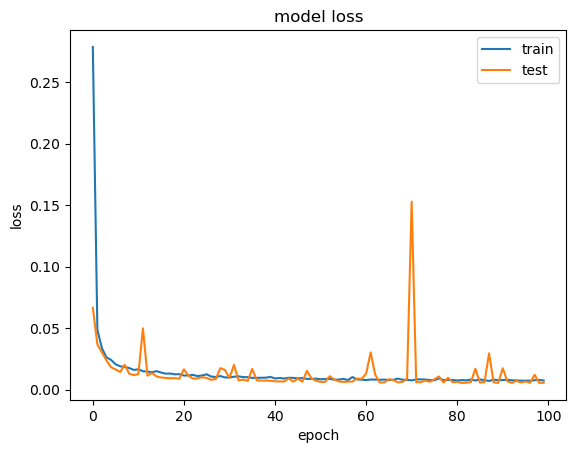

In [79]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

### Test

In [88]:
cae = load_model('fraudConv_AE.pth')

In [89]:
predictions = cae.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

2671/2671 [==============================] - 8s 3ms/step


,reconstruction_error,true_class
count,85443.000000,85443.00000
mean,0.006103,0.00165
std,0.194958,0.04059
min,0.000051,0.00000
25%,0.000283,0.00000
50%,0.000542,0.00000
75%,0.001385,0.00000
max,44.070155,1.00000


In [90]:
threshold = 2.9

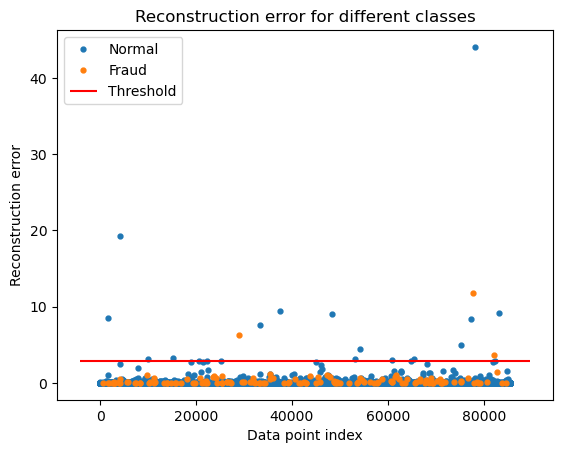

In [91]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

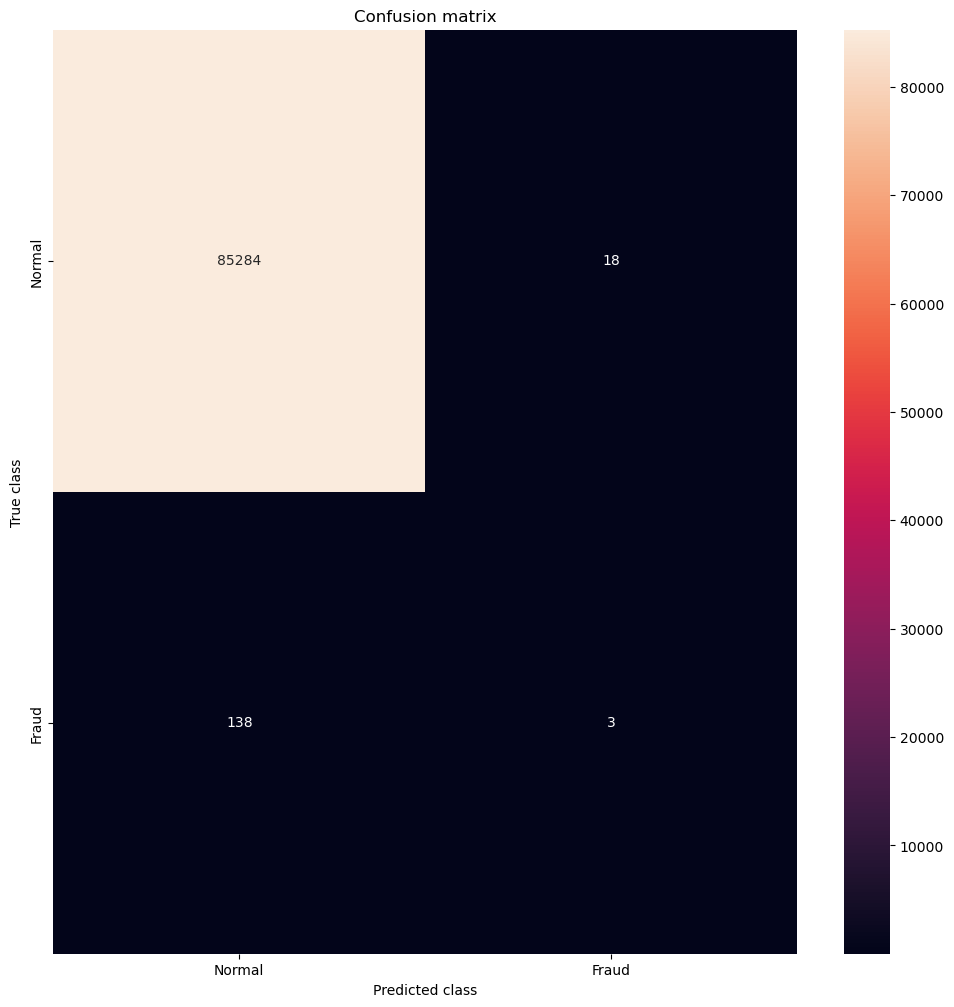

In [92]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
LABELS = ['Normal','Fraud']

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

### Visualize the latent space

In [107]:
inp_layer = cae.input
out_layer = cae.layers[5].output

encoder = Model(inputs=inp_layer, outputs=out_layer)

In [108]:
encoder.summary()

Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_40 (InputLayer)       [(None, 28)]              0         
                                                                 
 reshape_59 (Reshape)        (None, 28, 1)             0         
                                                                 
 conv1d_105 (Conv1D)         (None, 28, 14)            56        
                                                                 
 max_pooling1d_73 (MaxPooli  (None, 14, 14)            0         
 ng1D)                                                           
                                                                 
 conv1d_106 (Conv1D)         (None, 14, 7)             301       
                                                                 
 flatten_7 (Flatten)         (None, 98)                0         
                                                          

2671/2671 [==============================] - 6s 2ms/step


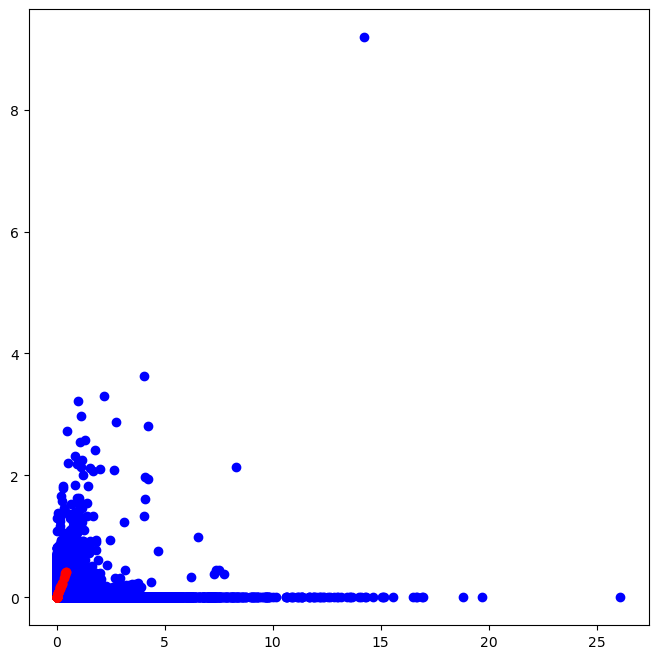

In [109]:
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

X_encoded = np.vstack((X_train_encoded, X_test_encoded))
y_main = np.hstack((np.zeros(len(X_train)), y_test))

encoded_df = pd.DataFrame(np.hstack((X_encoded, y_main[np.newaxis].transpose())))

label = 98;

plt.subplots(figsize=(8,8))
plt.scatter(encoded_df[encoded_df[label]==0][0],encoded_df[encoded_df[label]==0][1], color='blue', label='Normal')
plt.scatter(encoded_df[encoded_df[label]==1][1],encoded_df[encoded_df[label]==1][1], color='red', label='Fraud');